Przestawienie problemu. Zacznijmy od pewnego filmu. Oczywiście przedtem trzeba zaimportować odpowiednie biblioteki

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('Z44BZeF-ovk', width=640, height=360)

No właśnie? Czy w niedziele o godzinie 17 gorzej się gra w piłkę?

Najpierw zainstalujmy niezbędne pakiety

In [20]:
import kagglehub
import pandas as pd
from pathlib import Path, PurePath
import functions as f
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns ### ładowanie seaborn
import numpy as np


Teraz zaimportujmy dane i zróbmy pierwsze modyfikacje

In [ ]:
pd.set_option('display.max_columns', 18)

path = kagglehub.dataset_download("filippomonte/premier-league-past-3-seasons")
file = PurePath(Path(path).joinpath('PremierLeagueMatches.csv'))
df_raw = pd.read_csv(file)
df_raw.columns = [x.lower() for x in df_raw.columns]
df = df_raw.dropna(subset=['result'])

cols_to_drop = ['matchday',  'attendance', 'referee', 'stadium', 'result', '*additional stats']
df.drop(columns=cols_to_drop,inplace=True)


Index(['date', 'time', 'home team', 'homescore', 'homexg', 'awayscore',
       'awayxg', 'away team'],
      dtype='object')


C:\Users\mateu\AppData\Local\Temp\ipykernel_7908\630926254.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=cols_to_drop,inplace=True)


W następnym kroku wyciągnijmy z daty dzień tygodnia. Utworzymy nowe zmienne: 
- jedna kategoryczna - nazwa dnia tygodnia
- druga czy niedziela.

Ponadto na podstawie godziny wyciągniemy czy mecz o 17. Zaokrąglijmy początek meczu do pełnej godziny (do 30 zaokrąglamy w dół od 31 w górę). Następnie stworzymy kolejną zmienną, dla wyrównania liczebności zbiorów 16-18 to jest gra o 17.

Dodajmy do siebie zmienne zdobytych gole - tworząc zmienną total_goals
A także expected goals - tworzać zmienną total_excpected_goals

In [40]:
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.day_name()
df['sunday']=df['day_of_week'].apply(lambda x: 'Yes' if x=='Sunday' else 'No')
df['pure_hour'] = pd.to_datetime(df['time'], format='%H:%M')
df['pure_hour']=df['pure_hour'].apply(f.hours).dt.hour
df['seventeen']=df['pure_hour'].apply(lambda x: 'Yes' if x>=16 and x<=18 else 'No')
df['total_goals']=df['homescore']+df['awayscore']
df['total_xg']=df['homexg']+df['awayxg']
df['hard_time']=df.apply(lambda row: 'Yes' if row['sunday']=='Yes' and row['seventeen']=='Yes' else 'No', axis=1)


C:\Users\mateu\AppData\Local\Temp\ipykernel_7908\2579333999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
C:\Users\mateu\AppData\Local\Temp\ipykernel_7908\2579333999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['date'].dt.day_name()
C:\Users\mateu\AppData\Local\Temp\ipykernel_7908\2579333999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Sprawdźmy zatem główną tezę czy mecze w niedzielę o 17 są trudniejsze? 
Najpierw zobaczy czy liczba takich meczów jest odpowiednio duża

In [17]:
df.groupby('hard_time').size()

hard_time
No     950
Yes     99
dtype: int64

Prawie 100 meczów - myślimy, że dostatecznie liczna

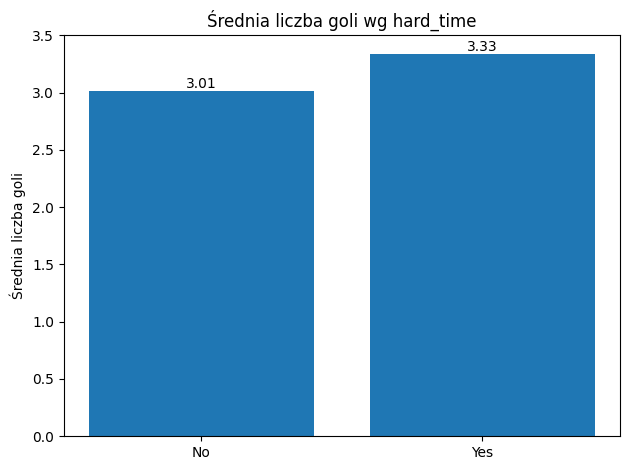

In [26]:
means = df.groupby('hard_time')['total_goals'].mean()

# Rysowanie wykresu
fig, ax = plt.subplots()
bars = ax.bar(means.index, means.values)

# Dodanie etykiet z wartością nad słupkami
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height:.2f}', ha='center', va='bottom')

ax.set_ylabel('Średnia liczba goli')
ax.set_title('Średnia liczba goli wg hard_time')
plt.tight_layout()
plt.show()

Teoria Piotrka się rozjeżdża, ale sprawdźmy może wpadają jakieś przypadkowe bramki, a wizualnie mecz to de facto expected goals

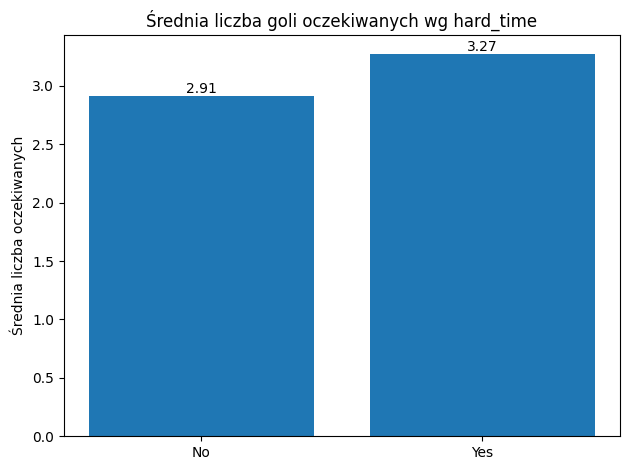

In [27]:
means = df.groupby('hard_time')['total_xg'].mean()

# Rysowanie wykresu
fig, ax = plt.subplots()
bars = ax.bar(means.index, means.values)

# Dodanie etykiet z wartością nad słupkami
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'{height:.2f}', ha='center', va='bottom')

ax.set_ylabel('Średnia liczba oczekiwanych')
ax.set_title('Średnia liczba goli oczekiwanych wg hard_time')
plt.tight_layout()
plt.show()

Niestety tutaj również nie da się stwierdzić, że to gorszy czas do gry w piłkę. 
Poszukajmy zatem jakichkolwiek argumentów sprawdźmy:
- powyższe teorie osobno dla niedzieli i dla 17
- rozkłady goli i oczekiwanych goli dla poszeczególnych miesięcy z uwzględnieniem hard_time
- sprawdźmy średnią liczbę goli w wykonaniu poszczególnych drużyn i ich częstość gry w niedzielę
- poszukujamy nowego hard_time 

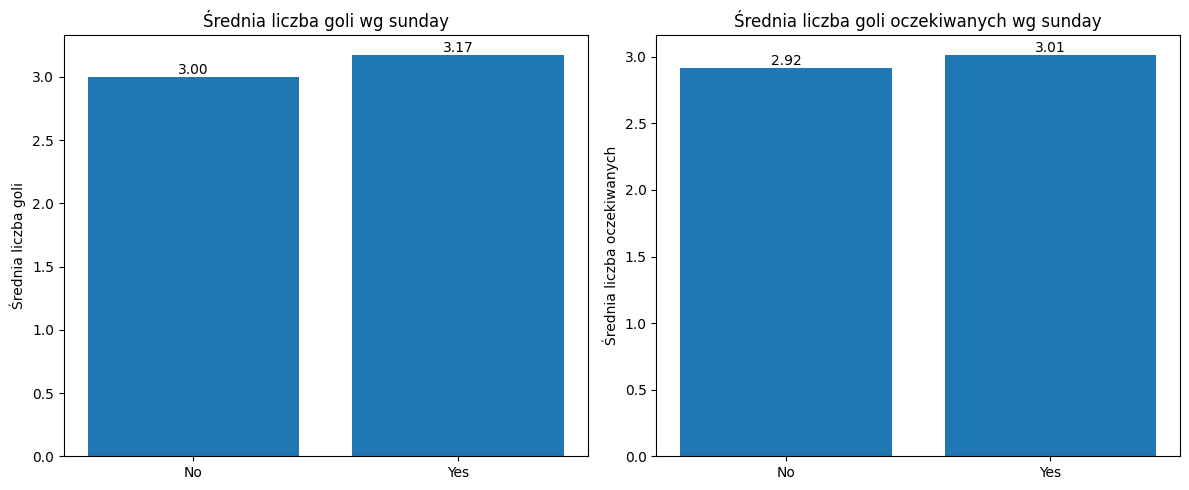

In [28]:
# Średnie
goals_mean = df.groupby('sunday')['total_goals'].mean()
xg_mean = df.groupby('sunday')['total_xg'].mean()

# Rysowanie obok siebie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Wykres 1 – total_goals
bars1 = axs[0].bar(goals_mean.index, goals_mean.values)
axs[0].set_title('Średnia liczba goli wg sunday')
axs[0].set_ylabel('Średnia liczba goli')

for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom')

# Wykres 2 – total_xg
bars2 = axs[1].bar(xg_mean.index, xg_mean.values)
axs[1].set_title('Średnia liczba goli oczekiwanych wg sunday')
axs[1].set_ylabel('Średnia liczba oczekiwanych')

for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()






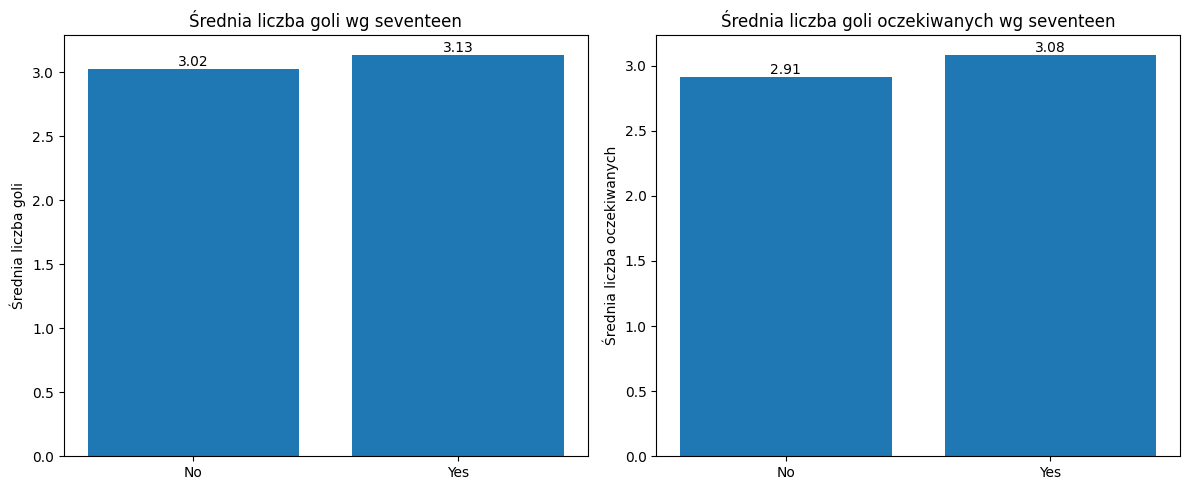

In [30]:
# Średnie
goals_mean = df.groupby('seventeen')['total_goals'].mean()
xg_mean = df.groupby('seventeen')['total_xg'].mean()

# Rysowanie obok siebie
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Wykres 1 – total_goals
bars1 = axs[0].bar(goals_mean.index, goals_mean.values)
axs[0].set_title('Średnia liczba goli wg seventeen')
axs[0].set_ylabel('Średnia liczba goli')

for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom')

# Wykres 2 – total_xg
bars2 = axs[1].bar(xg_mean.index, xg_mean.values)
axs[1].set_title('Średnia liczba goli oczekiwanych wg seventeen')
axs[1].set_ylabel('Średnia liczba oczekiwanych')

for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, height,
                f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [41]:
df['month'] = pd.to_datetime(df['date']).dt.month

C:\Users\mateu\AppData\Local\Temp\ipykernel_7908\1439146429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df['date']).dt.month


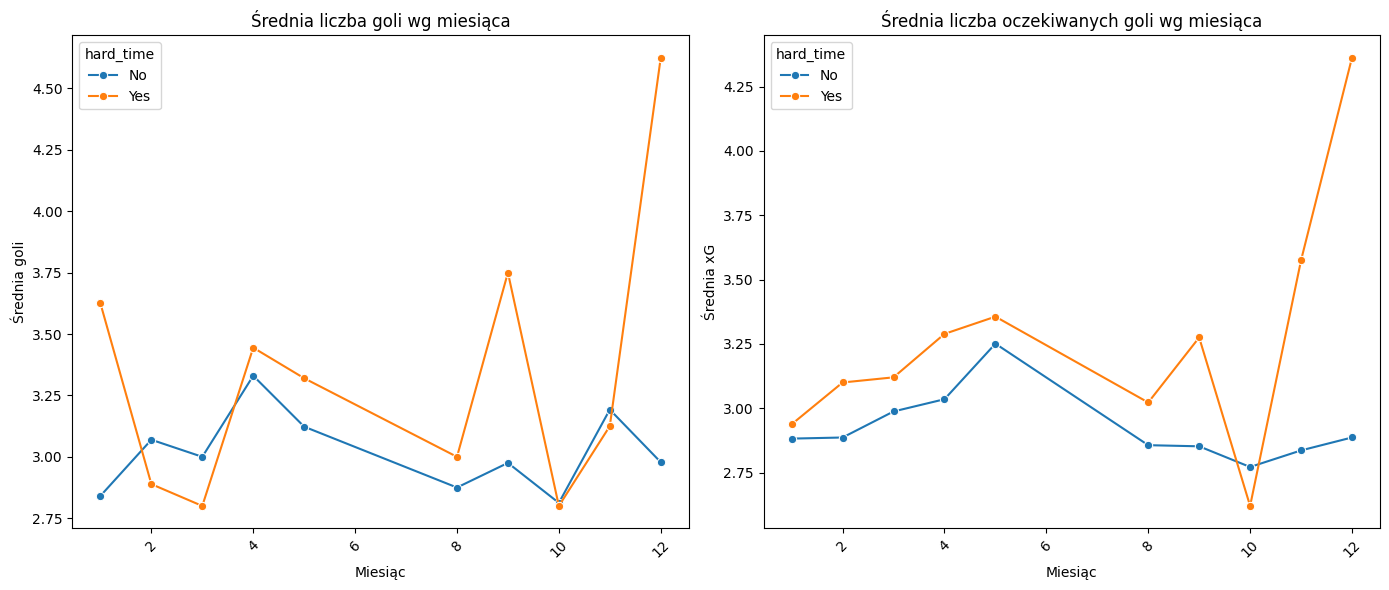

In [44]:
df_goals = df.groupby(['month', 'hard_time'])['total_goals'].mean().reset_index()
df_xg = df.groupby(['month', 'hard_time'])['total_xg'].mean().reset_index()

# Rysowanie dwóch wykresów
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Wykres 1 – realne gole
sns.lineplot(data=df_goals, x='month', y='total_goals', hue='hard_time', marker='o', ax=axs[0])
axs[0].set_title('Średnia liczba goli wg miesiąca')
axs[0].set_ylabel('Średnia goli')
axs[0].set_xlabel('Miesiąc')
axs[0].tick_params(axis='x', rotation=45)

# Wykres 2 – expected goals
sns.lineplot(data=df_xg, x='month', y='total_xg', hue='hard_time', marker='o', ax=axs[1])
axs[1].set_title('Średnia liczba oczekiwanych goli wg miesiąca')
axs[1].set_ylabel('Średnia xG')
axs[1].set_xlabel('Miesiąc')
axs[1].tick_params(axis='x', rotation=45)

# Przesunięcie legend, żeby nie były na słupkach
axs[0].legend(title='hard_time')
axs[1].legend(title='hard_time')

plt.tight_layout()
plt.show()



Możliwe, że wywiad jest z lutego bądź marca wtedy faktycznie w hardtime pada mniej goli, ewentualnie w październiku, wtedy mecze są mniej widowiskowe

C:\Users\mateu\AppData\Local\Temp\ipykernel_7908\406591347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)
C:\Users\mateu\AppData\Local\Temp\ipykernel_7908\406591347.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_day = df_long.groupby(['day_of_week', 'metric'])['value'].mean().reset_index()


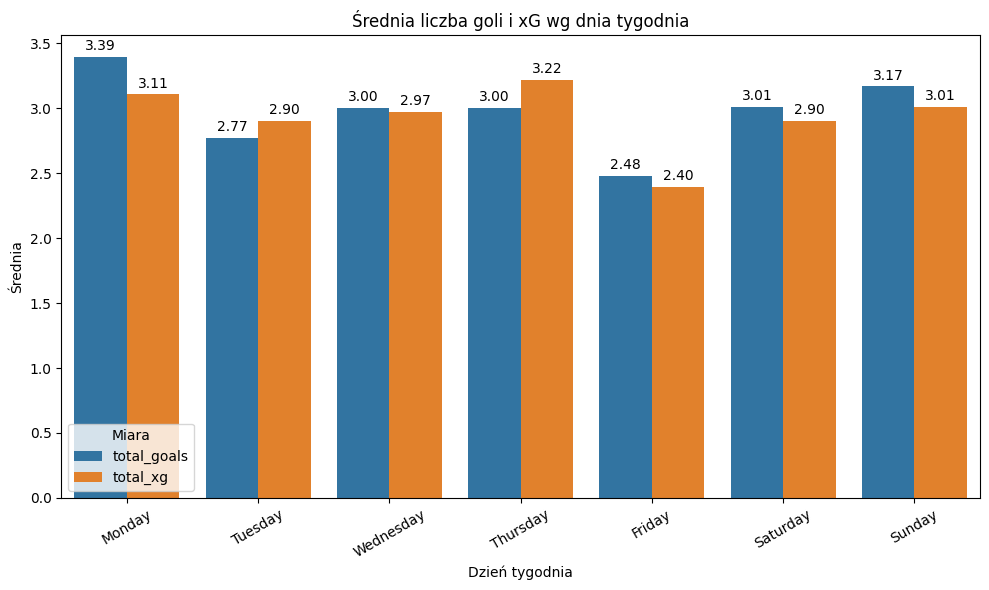

In [49]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=days_order, ordered=True)

# 🔧 Przekształcenie danych do długiego formatu
df_long = pd.melt(
    df,
    id_vars=['day_of_week'],
    value_vars=['total_goals', 'total_xg'],
    var_name='metric',
    value_name='value'
)

# 📊 Grupowanie – średnia
mean_by_day = df_long.groupby(['day_of_week', 'metric'])['value'].mean().reset_index()

# 🎨 Rysowanie
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_by_day, x='day_of_week', y='value', hue='metric')

# Etykiety nad słupkami
for container in plt.gca().containers:
    for bar in container:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.03, f'{height:.2f}', ha='center', va='bottom')

plt.title('Średnia liczba goli i xG wg dnia tygodnia')
plt.ylabel('Średnia')
plt.xlabel('Dzień tygodnia')
plt.xticks(rotation=30)
plt.legend(title='Miara')
plt.tight_layout()
plt.show()

Kandydatem na nowy hard time jest piątek

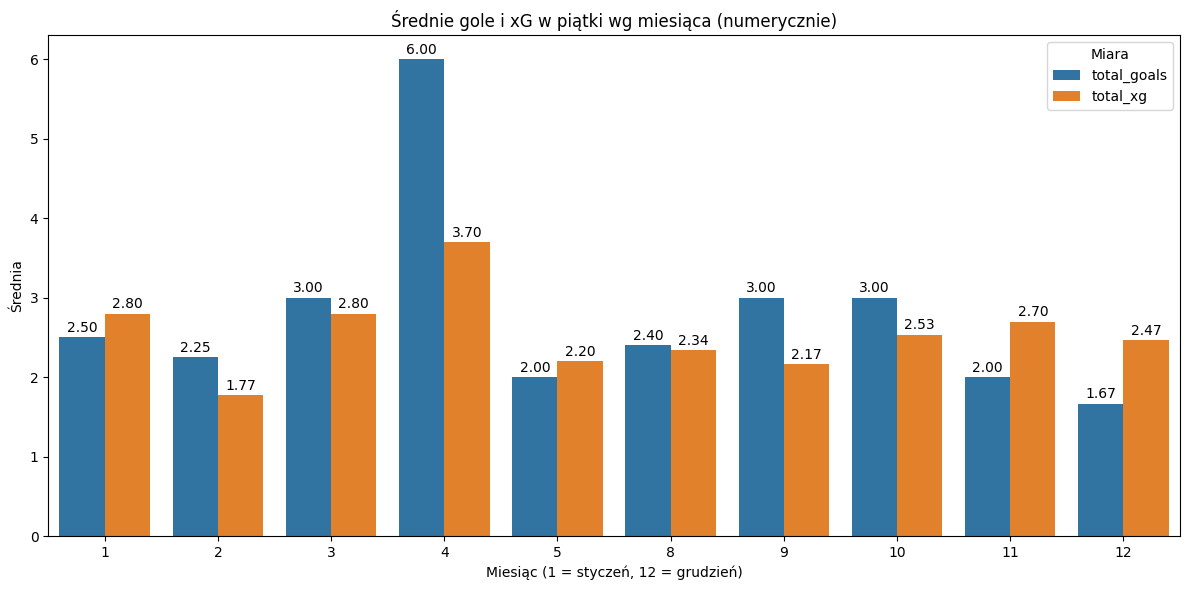

In [51]:
# Filtrowanie tylko piątków
friday_df = df[df['day_of_week'] == 'Friday'].copy()

# Długi format (total_goals i total_xg w jednej kolumnie)
friday_melted = pd.melt(
    friday_df,
    id_vars=['month'],
    value_vars=['total_goals', 'total_xg'],
    var_name='metric',
    value_name='value'
)

# Grupowanie: średnie w danym miesiącu
friday_grouped = friday_melted.groupby(['month', 'metric'])['value'].mean().reset_index()

# Rysowanie
plt.figure(figsize=(12, 6))
sns.barplot(data=friday_grouped, x='month', y='value', hue='metric')

# Etykiety nad słupkami
for container in plt.gca().containers:
    for bar in container:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.03, f'{height:.2f}', ha='center', va='bottom')

plt.title('Średnie gole i xG w piątki wg miesiąca (numerycznie)')
plt.ylabel('Średnia')
plt.xlabel('Miesiąc (1 = styczeń, 12 = grudzień)')
plt.xticks(rotation=0)
plt.legend(title='Miara')
plt.tight_layout()
plt.show()

Z tego co widać, to wizualnie najnudniejsze piątkowe mecze są w lutym, najbardziej marnują pilkarze sytuacje w listopadzie i grudniu, natomiast najwięcej przypadkowych goli jest w kwietniu

In [ ]:
# Dane gospodarzy
df_home = df[['date', 'home team', 'homescore', 'homexg', 'hard_time', 'day_of_week', 'month']].copy()
df_home.rename(columns={
    'home team': 'team',
    'homescore': 'goals',
    'homexg': 'xg'
}, inplace=True)

# Dane gości
df_away = df[['date', 'away team', 'awayscore', 'awayxg', 'hard_time', 'day_of_week', 'month']].copy()
df_away.rename(columns={
    'away team': 'team',
    'awayscore': 'goals',
    'awayxg': 'xg'
}, inplace=True)

# Łączenie
df_teams = pd.concat([df_home, df_away], ignore_index=True)

In [56]:
# Liczba meczów każdej drużyny
total_matches = df_teams.groupby('team').size().rename('matches')

# Średnie gole i xG
avg_goals = df_teams.groupby('team')['goals'].mean().rename('avg_goals')
avg_xg = df_teams.groupby('team')['xg'].mean().rename('avg_xg')

# Odsetek meczów w hard_time
hard_pct = df_teams[df_teams['hard_time'] == 'Yes'].groupby('team').size() / total_matches
hard_pct = hard_pct.rename('hard_time_pct').fillna(0)

# Odsetek meczów w piątek
friday_pct = df_teams[df_teams['day_of_week'] == 'Friday'].groupby('team').size() / total_matches
friday_pct = friday_pct.rename('friday_pct').fillna(0)

# Scalanie wszystkiego razem
team_stats = pd.concat([avg_goals, avg_xg, hard_pct, friday_pct], axis=1).reset_index()
print(team_stats)

               team  avg_goals    avg_xg  hard_time_pct  friday_pct
0           Arsenal   2.209524  1.830476       0.200000    0.028571
1       Aston Villa   1.600000  1.473333       0.076190    0.028571
2       Bournemouth   1.323810  1.400952       0.028571    0.000000
3         Brentford   1.561905  1.518095       0.028571    0.038095
4          Brighton   1.666667  1.650476       0.038095    0.038095
5           Burnley   1.078947  1.068421       0.026316    0.052632
6           Chelsea   1.600000  1.715238       0.133333    0.028571
7    Crystal Palace   1.278846  1.270192       0.019231    0.019231
8           Everton   1.009524  1.242857       0.038095    0.009524
9            Fulham   1.457143  1.302857       0.038095    0.038095
10     Ipswich Town   0.965517  0.934483       0.068966    0.034483
11     Leeds United   1.263158  1.247368       0.052632    0.026316
12   Leicester City   1.134328  1.134328       0.014925    0.044776
13        Liverpool   2.190476  2.134286       0

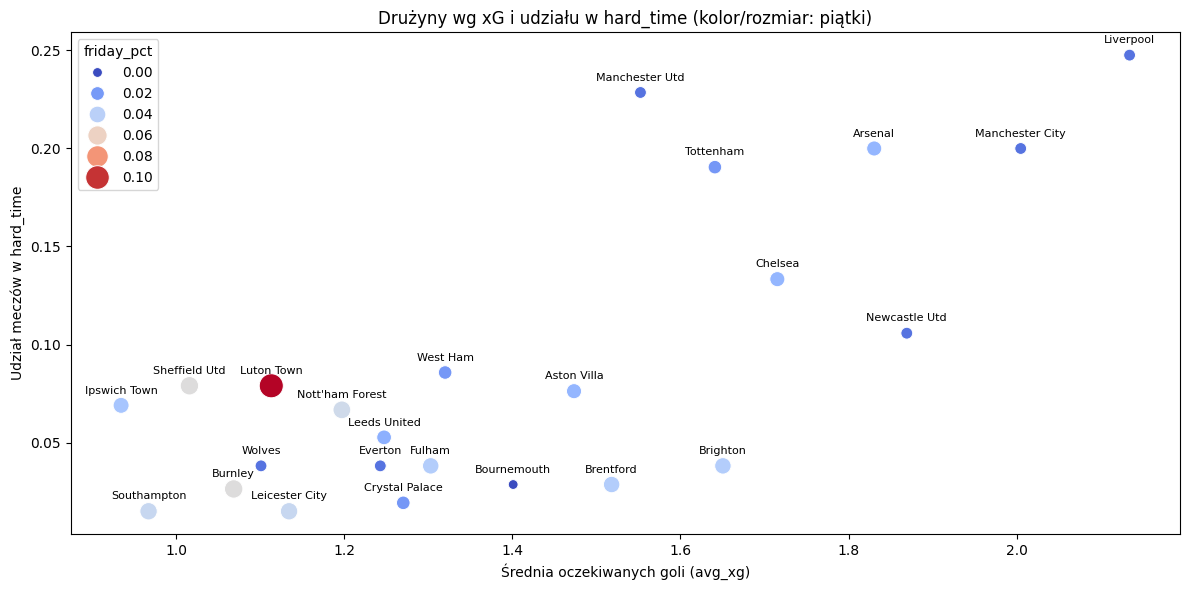

In [59]:
plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(
    data=team_stats,
    x='avg_xg',
    y='hard_time_pct',
    hue='friday_pct',
    palette='coolwarm',
    size='friday_pct',
    sizes=(50, 300),
    legend='brief'
)

# Dodajemy etykiety nazw drużyn
for _, row in team_stats.iterrows():
    plt.text(
        row['avg_xg'],
        row['hard_time_pct'] + 0.005,  # lekkie przesunięcie
        row['team'],
        ha='center',
        va='bottom',
        fontsize=8
    )

# Oznaczenia osi i tytuł
plt.xlabel('Średnia oczekiwanych goli (avg_xg)')
plt.ylabel('Udział meczów w hard_time')
plt.title('Drużyny wg xG i udziału w hard_time (kolor/rozmiar: piątki)')
plt.tight_layout()
plt.show()